In [ ]:
import pandas as pd

df = pd.read_csv("ratings.csv") 

df = df[['userId', 'movieId']]
df = df.drop_duplicates(subset=['userId', 'movieId'])
U = df['userId'].nunique()
item_counts = df.groupby('movieId')['userId'].nunique().rename("n_i")

df = df.merge(item_counts, left_on='movieId', right_index=True)

#  Contribution for each rating = (n_i - 1)
df['contrib'] = df['n_i'] - 1

user_sum = df.groupby('userId')['contrib'].sum().rename("sum_common_counts")

avg_common = (user_sum / (U - 1)).rename("avg_common")

result = pd.concat([user_sum, avg_common], axis=1).reset_index()

result.head()


,userId,sum_common_counts,avg_common
0,1,2514894,18.159128
1,2,845065,6.101905
2,3,2877140,20.774774
3,4,715230,5.164414
4,5,1786695,12.901070


In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import os


def compute_corating_statistics(ratings_df, progress_every=1000):

    print("Creating sparse user-item matrix...")

    users = ratings_df['userId'].unique()
    movies = ratings_df['movieId'].unique()

    user_map = {u: i for i, u in enumerate(users)}
    movie_map = {m: i for i, m in enumerate(movies)}

    rows = ratings_df['userId'].map(user_map).to_numpy()
    cols = ratings_df['movieId'].map(movie_map).to_numpy()
    data = np.ones(len(ratings_df), dtype=np.int32)

    R = csr_matrix((data, (rows, cols)), shape=(len(users), len(movies)))
    print(f"Matrix: {R.shape[0]:,} users × {R.shape[1]:,} movies")

    RT = R.T.tocsr()

    print("Computing co-rating statistics...")

    n_users = R.shape[0]
    results = []

    for u_idx in range(n_users):
        overlaps = R[u_idx].dot(RT).tocsr()

        idx = overlaps.indices
        vals = overlaps.data.astype(np.int32)

        mask = (idx != u_idx)
        vals = vals[mask]

        if vals.size > 0:
            avg_common = vals.mean()
            max_common = vals.max()
            min_common = vals.min()
        else:
            avg_common = 0.0
            max_common = 0
            min_common = 0

        results.append({
            'userId': users[u_idx],
            'avg_common': float(avg_common),
            'max_common': int(max_common),
            'min_common': int(min_common)
        })

        if (u_idx + 1) % progress_every == 0:
            print(f"  Progress: {u_idx+1:,}/{n_users:,} "
                  f"({100*(u_idx+1)/n_users:.1f}%)")

    return pd.DataFrame(results)



print("CO-RATING STATISTICS - SECTION 3 (CLUSTERING-BASED CF)")

ratings = pd.read_csv("ratings_statistics.csv")

print(f"Total ratings: {len(ratings):,}")
print(f"Total users: {ratings['userId'].nunique():,}")

print("\nUsing ALL users")
features = compute_corating_statistics(ratings)


output_path = "user_corating_features_all_users.csv"
features.to_csv(output_path, index=False)

features.to_csv(output_path, index=False)

print("\nRESULTS SAVED")
print(f"Path: {output_path}")
print(f"Total users saved: {len(features):,}")

CO-RATING STATISTICS - SECTION 3 (CLUSTERING-BASED CF)

Loading data...
Total ratings: 20,000,263
Total users: 138,493

Using ALL users
Creating sparse user-item matrix...
Matrix: 138,493 users × 26,744 movies
Computing co-rating statistics...
  Progress: 1,000/138,493 (0.7%)
  Progress: 2,000/138,493 (1.4%)
  Progress: 3,000/138,493 (2.2%)
  Progress: 4,000/138,493 (2.9%)
  Progress: 5,000/138,493 (3.6%)
  Progress: 6,000/138,493 (4.3%)
  Progress: 7,000/138,493 (5.1%)
  Progress: 8,000/138,493 (5.8%)
  Progress: 9,000/138,493 (6.5%)
  Progress: 10,000/138,493 (7.2%)
  Progress: 11,000/138,493 (7.9%)
  Progress: 12,000/138,493 (8.7%)
  Progress: 13,000/138,493 (9.4%)
  Progress: 14,000/138,493 (10.1%)
  Progress: 15,000/138,493 (10.8%)
  Progress: 16,000/138,493 (11.6%)
  Progress: 17,000/138,493 (12.3%)
  Progress: 18,000/138,493 (13.0%)
  Progress: 19,000/138,493 (13.7%)
  Progress: 20,000/138,493 (14.4%)
  Progress: 21,000/138,493 (15.2%)
  Progress: 22,000/138,493 (15.9%)
  Progre

In [ ]:
import pandas as pd
df = pd.read_csv("user_corating_features_all_users.csv")

user_ids = df['userId']
features = df[['avg_common', 'max_common', 'min_common']]

# 2.1 Compute mean (μ) and std (σ) for each feature 
means = features.mean()
stds = features.std()

print("Means:\n", means)
print("\nStandard deviations:\n", stds)

# 2.2 Apply Z-score normalization 
df_normalized = (features - means) / stds
df_normalized.insert(0, 'userId', user_ids)
print("\nNormalized sample:\n", df_normalized.head())




Means:
 avg_common     14.832657
max_common    138.627620
min_common      1.000245
dtype: float64

Standard deviations:
 avg_common     13.751917
max_common    206.586686
min_common      0.020463
dtype: float64

Normalized sample:
    userId  avg_common  max_common  min_common
0       1    0.274044    0.142179   -0.011997
1       2   -0.582962   -0.380604   -0.011997
2       3    0.451013    0.229310   -0.011997
3       4   -0.615459   -0.535502   -0.011997
4       5   -0.075645   -0.351560   -0.011997

Saved normalized_user_features.csv


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

df = pd.read_csv(
    "user_corating_features_all_users.csv"
)

user_ids = df['userId']
X = df[['avg_common', 'max_common', 'min_common']]

K_values = [5, 10, 15, 20, 30, 50]

for k in K_values:
    print(f"\nRunning K-means for K = {k} ...")

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    output = pd.DataFrame({
        'userId': user_ids,
        'cluster': labels
    })

    output.to_csv(
        "user_clusters_K{k}.csv",
        index=False
    )

    print(f"Saved clusters for K={k}")



Running K-means for K = 5 ...
Saved clusters for K=5

Running K-means for K = 10 ...
Saved clusters for K=10

Running K-means for K = 15 ...
Saved clusters for K=15

Running K-means for K = 20 ...
Saved clusters for K=20

Running K-means for K = 30 ...
Saved clusters for K=30

Running K-means for K = 50 ...
Saved clusters for K=50


In [3]:
for k in K_values:
    print(f"Centroids for K = {k}")


    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    centroids = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=X.columns
    )

    for i, row in centroids.iterrows():
        print(
            f"Cluster {i}: "
            f"avg_common={row['avg_common']:.2f}, "
            f"max_common={row['max_common']:.2f}, "
            f"min_common={row['min_common']:.2f}"
        )


Centroids for K = 5
Cluster 0: avg_common=8.42, max_common=55.57, min_common=1.00
Cluster 1: avg_common=42.61, max_common=502.02, min_common=1.00
Cluster 2: avg_common=23.95, max_common=219.21, min_common=1.00
Cluster 3: avg_common=64.40, max_common=1006.90, min_common=1.00
Cluster 4: avg_common=90.03, max_common=2053.26, min_common=1.09
Centroids for K = 10
Cluster 0: avg_common=6.40, max_common=37.59, min_common=1.00
Cluster 1: avg_common=51.54, max_common=681.29, min_common=1.00
Cluster 2: avg_common=21.45, max_common=187.76, min_common=1.00
Cluster 3: avg_common=91.31, max_common=2090.21, min_common=1.06
Cluster 4: avg_common=30.78, max_common=306.12, min_common=1.00
Cluster 5: avg_common=76.32, max_common=1379.85, min_common=1.00
Cluster 6: avg_common=40.91, max_common=465.30, min_common=1.00
Cluster 7: avg_common=63.88, max_common=977.09, min_common=1.00
Cluster 8: avg_common=110.31, max_common=3509.73, min_common=1.70
Cluster 9: avg_common=13.39, max_common=100.07, min_common=1.

Plotting bar chart for K = 5


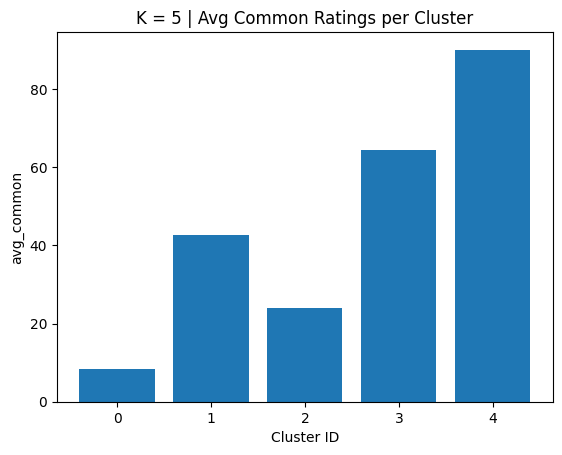

Plotting bar chart for K = 10


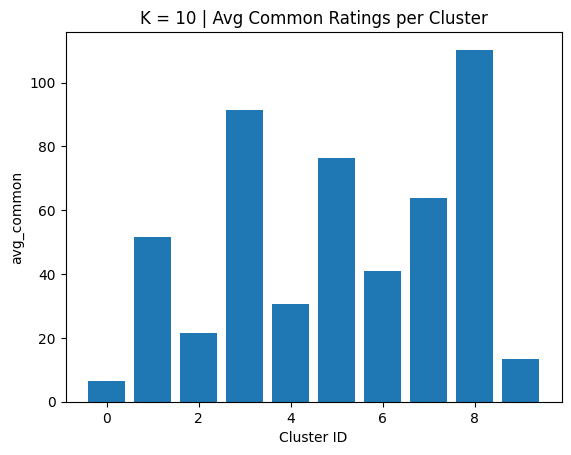

Plotting bar chart for K = 15


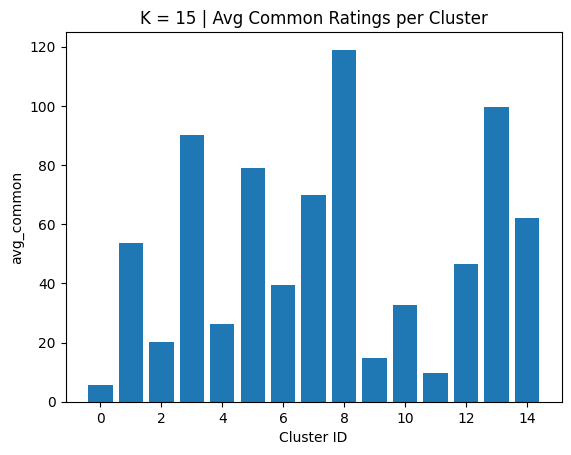

Plotting bar chart for K = 20


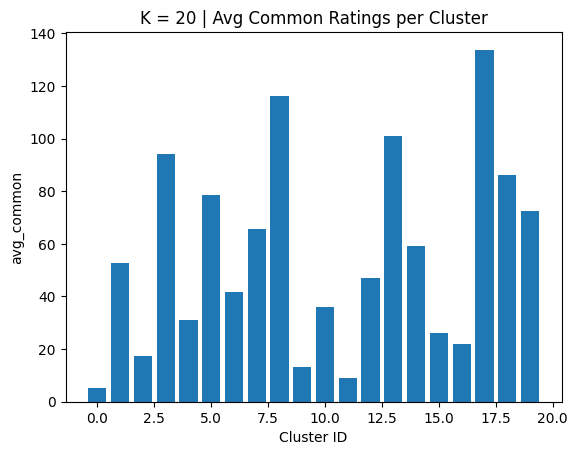

Plotting bar chart for K = 30


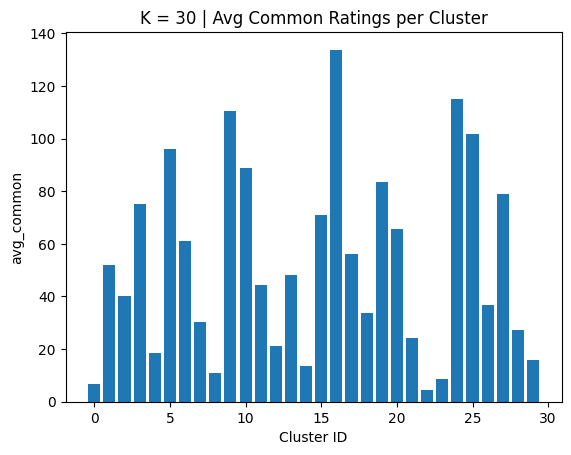

Plotting bar chart for K = 50


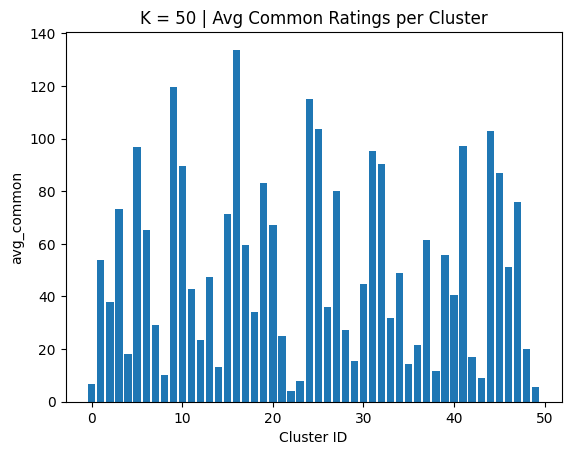

In [4]:
import matplotlib.pyplot as plt
for k in K_values:
    print(f"Plotting bar chart for K = {k}")

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    centroids = pd.DataFrame(
        kmeans.cluster_centers_,
        columns=X.columns
    )

    # BAR CHART 
    plt.figure()
    plt.bar(range(k), centroids['avg_common'])
    plt.xlabel("Cluster ID")
    plt.ylabel("avg_common")
    plt.title(f"K = {k} | Avg Common Ratings per Cluster")
    plt.show()


Plotting K = 5...


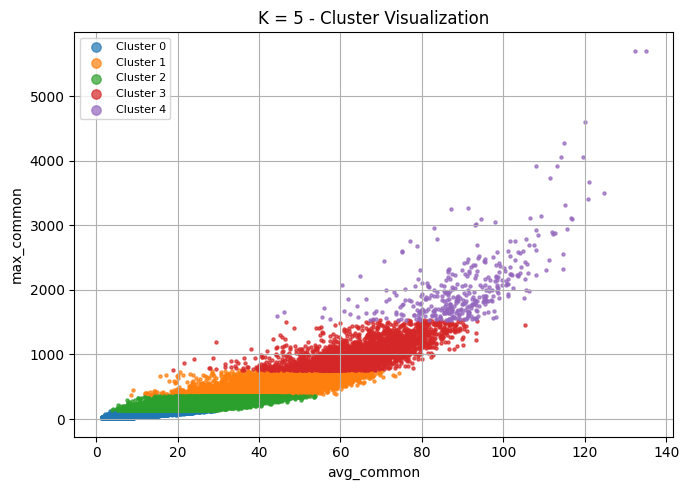

Plotting K = 10...


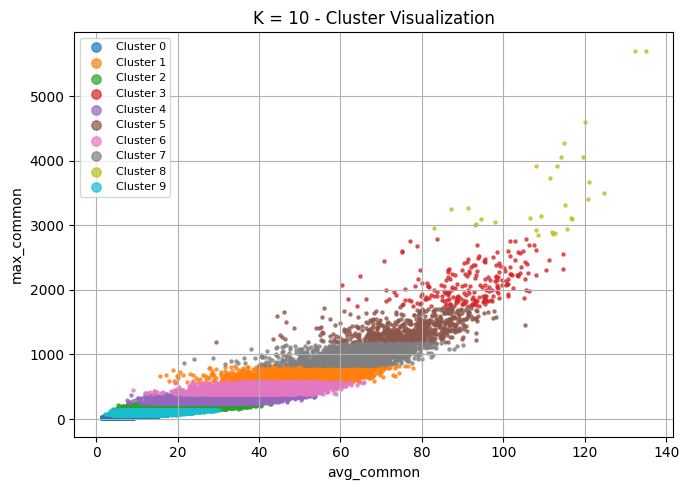

Plotting K = 15...


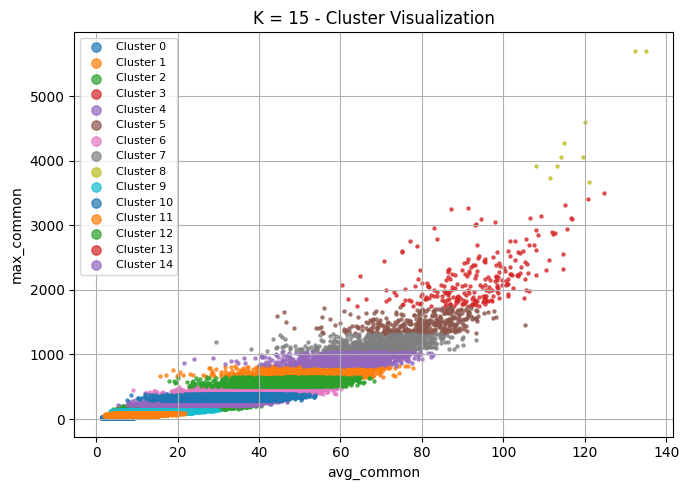

Plotting K = 20...


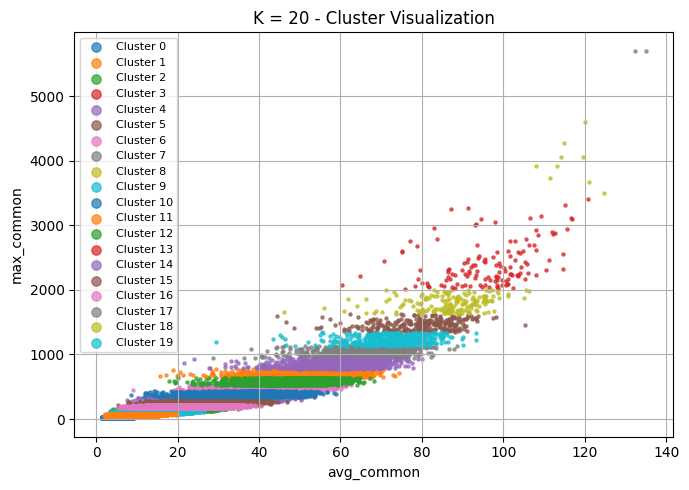

Plotting K = 30...


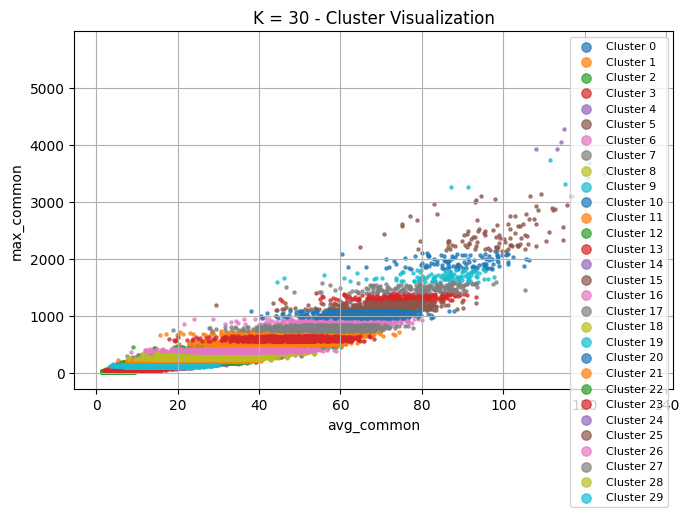

Plotting K = 50...


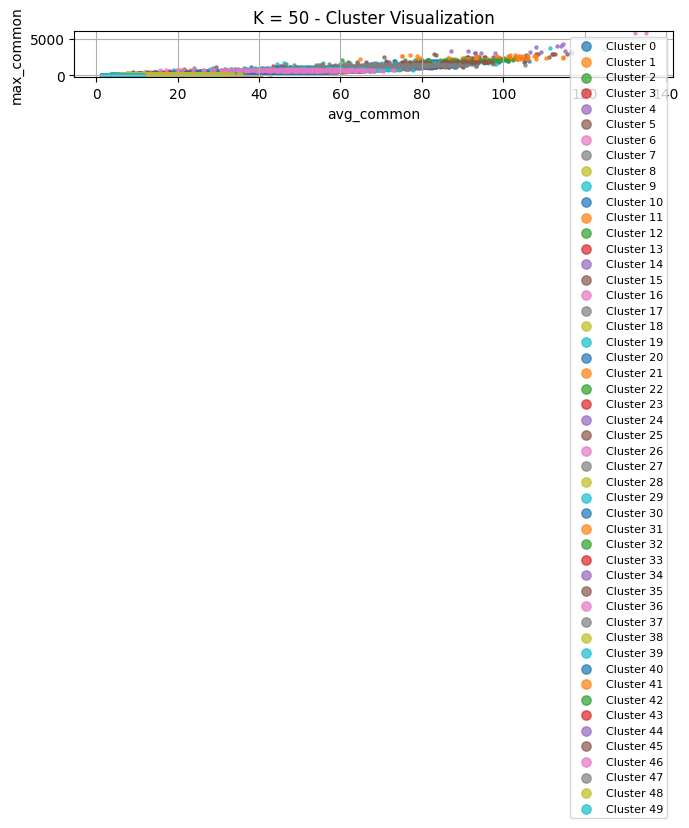

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
output.to_csv(
    "user_clusters_K{k}.csv",
    index=False
)

for k in K_values:
    print(f"Plotting K = {k}...")
    
    clusters = pd.read_csv(
        "user_clusters_K{k}.csv"
    )
    
    data = df.merge(clusters, on="userId")

    plt.figure(figsize=(7, 5))
    for cluster_id in sorted(data['cluster'].unique()):
        cluster_data = data[data['cluster'] == cluster_id]
        plt.scatter(
            cluster_data['avg_common'],
            cluster_data['max_common'],
            s=5,
            label=f"Cluster {cluster_id}",
            alpha=0.7
        )

    plt.title(f"K = {k} - Cluster Visualization")
    plt.xlabel("avg_common")
    plt.ylabel("max_common")
    plt.legend(markerscale=3, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



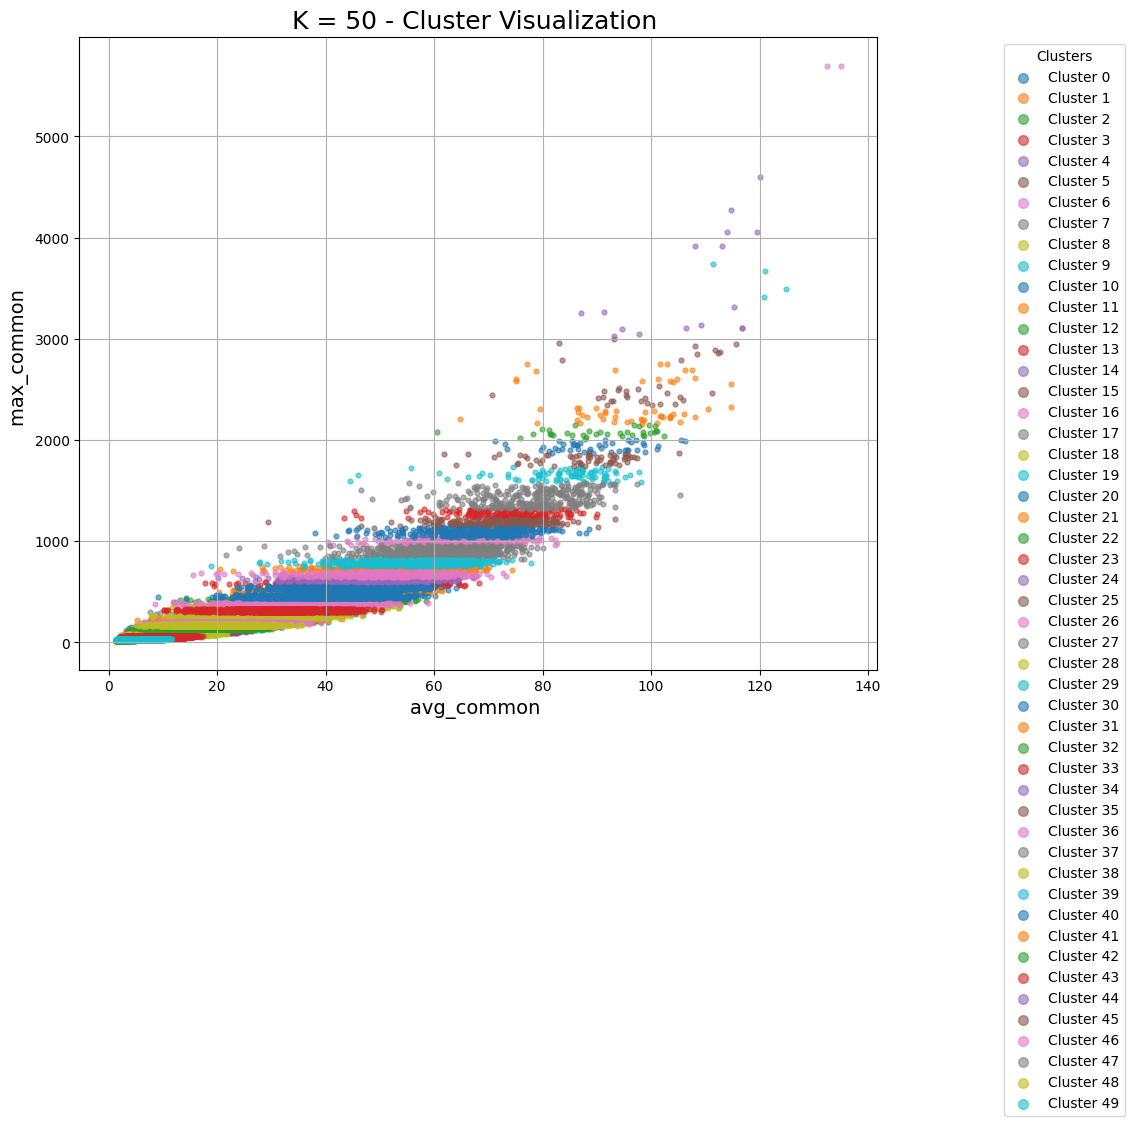

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

clusters = pd.read_csv("user_clusters_K50.csv")
data = df.merge(clusters, on="userId")
plt.figure(figsize=(15, 10))
for cluster_id in sorted(data["cluster"].unique()):
    cluster_data = data[data["cluster"] == cluster_id]
    plt.scatter(
        cluster_data["avg_common"],
        cluster_data["max_common"],
        s=12,           
        alpha=0.6,
        label=f"Cluster {cluster_id}"
    )

plt.title("K = 50 - Cluster Visualization ", fontsize=18)
plt.xlabel("avg_common ", fontsize=14)
plt.ylabel("max_common ", fontsize=14)
plt.legend(
    title="Clusters",
    bbox_to_anchor=(1.15, 1),
    loc='upper left',
    fontsize=10,
    markerscale=2
)

plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.80, 1])

plt.show()



In [ ]:
#3.3 Calculate WCSS and silhouette scores for each K.
def silhouette(X, labels):

    n = len(X)
    unique_labels = np.unique(labels)
    silhouette_vals = []

    # Precompute distance matrix (n x n)
    D = np.linalg.norm(X[:, None] - X[None, :], axis=2)

    for i in range(n):
        own_cluster = labels[i]

        # 1. a(i): mean distance to same cluster points
        same_mask = (labels == own_cluster)
        same_mask[i] = False

        if same_mask.sum() > 0:
            a = D[i, same_mask].mean()
        else:
            a = 0

        # 2. b(i): nearest other cluster
        b = float("inf")
        for c in unique_labels:
            if c == own_cluster:
                continue
            other_mask = (labels == c)
            if other_mask.sum() > 0:
                dist = D[i, other_mask].mean()
                b = min(b, dist)

        # Silhouette(i)
        s = (b - a) / max(a, b) if max(a, b) > 0 else 0
        silhouette_vals.append(s)

    return np.mean(silhouette_vals)

X = df[['avg_common', 'max_common', 'min_common']].values


# Results storage
results = []

# Sample for manual silhouette (faster)
sample_size = 2000
idx = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[idx]


for k in K_values:
    print(f"\nRunning K = {k} ...")

    # Kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    # WCSS
    wcss = kmeans.inertia_

    # Predict sample labels using trained centroids
    sample_labels = kmeans.predict(X_sample)

    # Manual silhouette
    sil_score = silhouette(X_sample, sample_labels)

    # Print results
    print(f"WCSS = {wcss:.2f}")
    print(f"Silhouette = {sil_score:.4f}")

    results.append([k, wcss, sil_score])






Running K = 5 ...
WCSS = 528190323.20
Silhouette = 0.6742

Running K = 10 ...
WCSS = 151653596.79
Silhouette = 0.5973

Running K = 15 ...
WCSS = 70617468.55
Silhouette = 0.5544

Running K = 20 ...
WCSS = 40682191.61
Silhouette = 0.5479

Running K = 30 ...
WCSS = 19239670.96
Silhouette = 0.4972

Running K = 50 ...
WCSS = 8094507.42
Silhouette = 0.4278


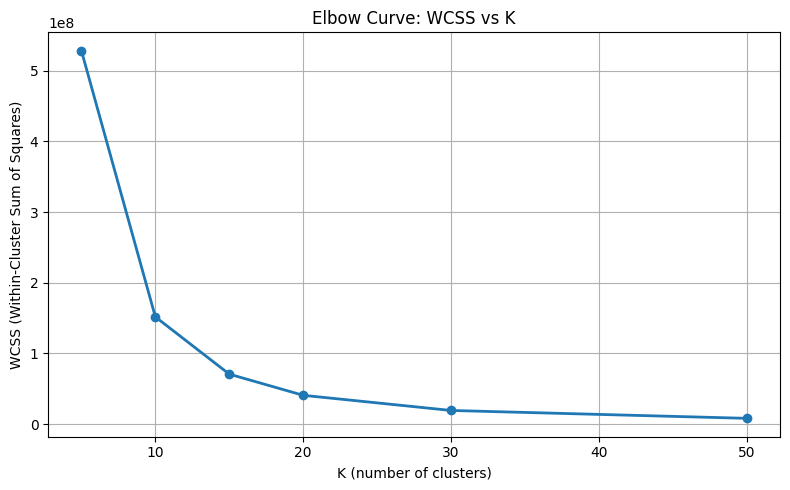

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("kmeans_metrics.csv")
K_values = df["K"]
wcss_values = df["WCSS"]

plt.figure(figsize=(8,5))
plt.plot(K_values, wcss_values, marker='o', linewidth=2)
plt.xlabel("K (number of clusters)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Curve: WCSS vs K")
plt.grid(True)
plt.tight_layout()
plt.show()


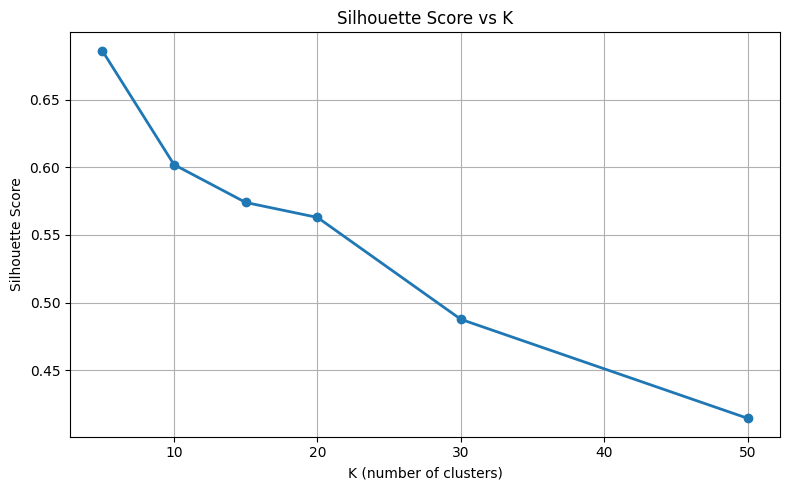

In [ ]:
import matplotlib.pyplot as plt
K_values = df["K"]
sil_scores = df["Silhouette"]

plt.figure(figsize=(8,5))
plt.plot(K_values, sil_scores, marker='o', linewidth=2)
plt.xlabel("K (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#5.1. Calculate the average co-rating statistics for users in each cluster.

import pandas as pd

features = pd.read_csv(
    "ser_corating_features_all_users.csv"
)

clusters = pd.read_csv(
    "user_clusters_K5.csv"
)

data = features.merge(clusters, on="userId")

print("Users:", len(data))
print("Clusters:", data["cluster"].nunique())


Users: 138493
Clusters: 5


In [21]:
cluster_stats = (
    data.groupby("cluster")[["avg_common", "max_common", "min_common"]]
    .mean()
    .reset_index()
)

# Sort by avg_common
cluster_stats = cluster_stats.sort_values(
    by="avg_common", ascending=False
)

print("\nCluster statistics:")
print(cluster_stats)


Cluster statistics:
   cluster  avg_common   max_common  min_common
4        4   90.026201  2053.256065    1.091644
3        3   64.386618  1006.611552    1.000000
1        1   42.588530   501.660465    1.000000
2        2   23.935364   219.019589    1.000000
0        0    8.414645    55.547725    1.000000


In [22]:
# 5.2 High / Low overlap clusters

high_overlap = cluster_stats.head(3)["cluster"].tolist()
low_overlap = cluster_stats.tail(3)["cluster"].tolist()

print("\nHigh-overlap clusters:", high_overlap)
print("Low-overlap clusters:", low_overlap)


High-overlap clusters: [4, 3, 1]
Low-overlap clusters: [1, 2, 0]


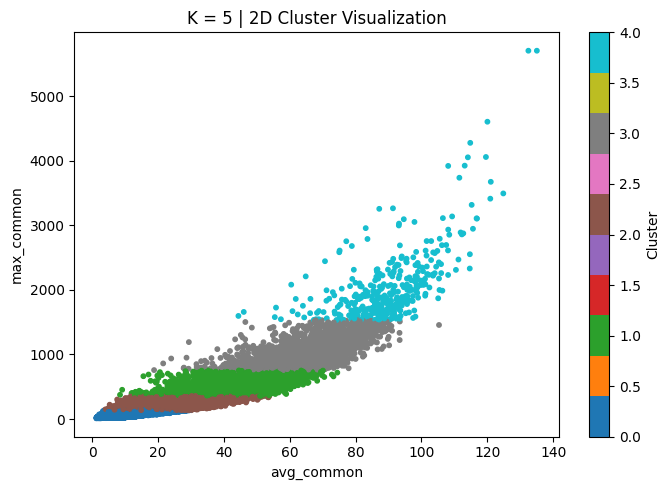

In [23]:
import matplotlib.pyplot as plt

# 2D Visualization
plt.figure(figsize=(7, 5))
plt.scatter(
    data["avg_common"],
    data["max_common"],
    c=data["cluster"],
    cmap="tab10",
    s=10
)
plt.xlabel("avg_common")
plt.ylabel("max_common")
plt.title("K = 5 | 2D Cluster Visualization")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()


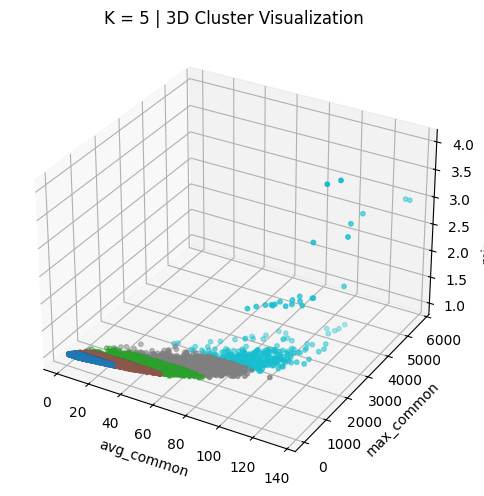

In [25]:
from mpl_toolkits.mplot3d import Axes3D
# 3D Visualization
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    data["avg_common"],
    data["max_common"],
    data["min_common"],
    c=data["cluster"],
    cmap="tab10",
    s=10
)

ax.set_xlabel("avg_common")
ax.set_ylabel("max_common")
ax.set_zlabel("min_common")
ax.set_title("K = 5 | 3D Cluster Visualization")

plt.tight_layout()
plt.show()

In [ ]:
#6.1identify  cluster  For each target user
# Target users
target_users = [69251, 69481, 67075]
result = clusters[clusters["userId"].isin(target_users)]
print("Target Users and Their Cluster Assignments:")
print(result)


Target Users and Their Cluster Assignments:
       userId  cluster
67074   67075        3
69250   69251        2
69480   69481        3


In [ ]:
ratings_path  = "ratings_statistics.csv"
clusters_path = "user_clusters_K5.csv"  # 

target_users = {
    "U1": 69251,
    "U2": 69481,
    "U3": 67075
}

print("Loading ratings...")
ratings_df = pd.read_csv(ratings_path)[["userId", "movieId", "rating"]]

print("Loading clusters...")
clusters_df = pd.read_csv(clusters_path)     # columns: userId, cluster

print("Total ratings:", len(ratings_df))
print("Total users:", ratings_df["userId"].nunique())
print("Total clusters:", clusters_df["cluster"].nunique())

Loading ratings...
Loading clusters...
Total ratings: 20000263
Total users: 138493
Total clusters: 5


In [ ]:
def mean_centered_cosine(u_ratings, v_ratings):
    common = u_ratings.index.intersection(v_ratings.index)
    if len(common) == 0:
        return 0.0, 0

    u_vec = u_ratings.loc[common].values
    v_vec = v_ratings.loc[common].values

    num = np.dot(u_vec, v_vec)
    den = np.linalg.norm(u_vec) * np.linalg.norm(v_vec)
    sim = num / den if den != 0 else 0.0
    return sim, len(common)

for name, target_user in target_users.items():

    print(f"\nProcessing {name} (userId={target_user})")

    # 6.1: find cluster of target user
    if target_user not in clusters_df["userId"].values:
        print(f"  WARNING: target user {target_user} not found in clusters file.")
        continue

    cluster_id = clusters_df.loc[
        clusters_df["userId"] == target_user, "cluster"
    ].iloc[0]

    print(f"  Cluster ID = {cluster_id}")

    # users in the same cluster
    cluster_users = clusters_df[clusters_df["cluster"] == cluster_id]["userId"]
    cluster_ratings = ratings_df[ratings_df["userId"].isin(cluster_users)]

    print(f"  Users in cluster: {cluster_users.nunique()}")
    print(f"  Ratings in cluster: {len(cluster_ratings)}")

    # build mean-centered rating vectors for all users in this cluster
    user_vectors = {}
    for uid, grp in cluster_ratings.groupby("userId"):
        s = grp.set_index("movieId")["rating"]
        user_vectors[uid] = s - s.mean()      # mean-centered

    if target_user not in user_vectors:
        print("  WARNING: target user has no ratings in this cluster subset.")
        continue

    target_vec = user_vectors[target_user]

    rows = []
    for other, other_vec in user_vectors.items():
        if other == target_user:
            continue
        sim, common = mean_centered_cosine(target_vec, other_vec)
        rows.append((other, sim, common))

    sim_df = (
        pd.DataFrame(rows, columns=["userId", "similarity", "common_count"])
        .sort_values("similarity", ascending=False)
    )

    print("  Top 5 neighbors:")
    print(sim_df.head(5))


Processing U1 (userId=69251)
  Cluster ID = 2
  Users in cluster: 26239
  Ratings in cluster: 5893450
  Top 5 neighbors:
       userId  similarity  common_count
95        534         1.0             3
25687  135575         1.0             2
22853  120269         1.0             3
22082  116116         1.0             2
2766    14302         1.0             3

Processing U2 (userId=69481)
  Cluster ID = 3
  Users in cluster: 2649
  Ratings in cluster: 2896704
  Top 5 neighbors:
      userId  similarity  common_count
792    40938    0.618695           177
2259  117315    0.565375           265
217    11333    0.562671           377
2133  110255    0.556770           221
1116   58228    0.555079           213

Processing U3 (userId=67075)
  Cluster ID = 3
  Users in cluster: 2649
  Ratings in cluster: 2896704
  Top 5 neighbors:
      userId  similarity  common_count
2414  125972    0.462029           474
1898   97984    0.438637           458
726    37319    0.437396           538
802   

In [42]:
base_path = r"D:\is\section3"
users = ["U1", "U2", "U3"]

B_PCT = 0.30   # β = 30%

for name in users:
    in_path  = fr"{base_path}\similarity_{name}.csv"
    out_path = fr"{base_path}\similarity_{name}_DS.csv"

    print(f"\nProcessing Step 6.3 for {name}")

    df = pd.read_csv(in_path)

    max_common = df["common_count"].max()
    threshold = B_PCT * max_common

    if threshold == 0:
        df["DF"] = 0.0
    else:
        # DF = min(common_count / β, 1)
        df["DF"] = (df["common_count"] / threshold).clip(upper=1.0)

    # Discounted Similarity
    df["DS"] = df["DF"] * df["similarity"]

    # Save result
    df.to_csv(out_path, index=False)

    print(f"Saved → {out_path}")
    print(df[["userId", "similarity", "common_count", "DF", "DS"]].head())



Processing Step 6.3 for U1
Saved → D:\is\section3\similarity_U1_DS.csv
   userId  similarity  common_count        DF        DS
0     534         1.0             3  0.119048  0.119048
1  135575         1.0             2  0.079365  0.079365
2  120269         1.0             3  0.119048  0.119048
3  116116         1.0             2  0.079365  0.079365
4   14302         1.0             3  0.119048  0.119048

Processing Step 6.3 for U2
Saved → D:\is\section3\similarity_U2_DS.csv
   userId  similarity  common_count        DF        DS
0   40938    0.618695           177  0.996622  0.616605
1  117315    0.565375           265  1.000000  0.565375
2   11333    0.562671           377  1.000000  0.562671
3  110255    0.556770           221  1.000000  0.556770
4   58228    0.555079           213  1.000000  0.555079

Processing Step 6.3 for U3
Saved → D:\is\section3\similarity_U3_DS.csv
   userId  similarity  common_count   DF        DS
0  125972    0.462029           474  1.0  0.462029
1   97984 

In [34]:
import pandas as pd

base_path = r"D:\is\section3"
users = ["U1", "U2", "U3"]

TOP_PCT = 0.20   # top 20%

for name in users:
    print(f"\nProcessing Step  for {name}")

    # load DS file
    df = pd.read_csv(
        fr"{base_path}\similarity_{name}_DS.csv"
    )

    n = len(df)
    top_n = max(1, int(TOP_PCT * n))

    # sort by DS descending
    df_top = df.sort_values("DS", ascending=False).head(top_n)

    print(f"Top {int(TOP_PCT*100)}% neighbors ({top_n} users):")
    print(df_top.head(10))   # show first 10 only



Processing Step  for U1
Top 20% neighbors (5247 users):
     userId  similarity  common_count        DF        DS
277   11099    0.826665            28  1.000000  0.826665
500   44552    0.730409            35  1.000000  0.730409
488   53233    0.735338            25  0.992063  0.729502
538    8306    0.720126            27  1.000000  0.720126
598   52667    0.706797            25  0.992063  0.701188
530   32128    0.721725            24  0.952381  0.687357
701   77096    0.681949            35  1.000000  0.681949
677   56357    0.685911            25  0.992063  0.680467
721   50847    0.677949            30  1.000000  0.677949
731   23316    0.674609            30  1.000000  0.674609

Processing Step  for U2
Top 20% neighbors (529 users):
   userId  similarity  common_count        DF        DS
0   40938    0.618695           177  0.996622  0.616605
1  117315    0.565375           265  1.000000  0.565375
2   11333    0.562671           377  1.000000  0.562671
3  110255    0.556770    

In [35]:
import pandas as pd
import numpy as np

target_users = {
    "U1": 69251,
    "U2": 69481,
    "U3": 67075
}

items = {
    "I1": 116181,
    "I2": 106503,
    "I3": 8860
}


user_mean = ratings_df.groupby("userId")["rating"].mean()

# 2. predict rating for one (user, item)
def predict_rating(target_id, item_id, neighbors_df):

    # neighbors who have rated this item
    neigh_ids = neighbors_df["userId"].unique()
    mask = (ratings_df["movieId"] == item_id) & (ratings_df["userId"].isin(neigh_ids))
    item_ratings = ratings_df[mask]

    if item_ratings.empty:
        # no neighbor has rated this item
        return np.nan

    # merge to attach DS to each neighbor rating
    merged = item_ratings.merge(
        neighbors_df[["userId", "DS"]],
        on="userId",
        how="inner"
    )

    # drop zero-DS neighbors (if any)
    merged = merged[merged["DS"] != 0]
    if merged.empty:
        return np.nan

    # target user's mean rating
    mu_u = user_mean.get(target_id, np.nan)
    if np.isnan(mu_u):
        return np.nan

    # each neighbor's mean rating
    merged["mu_v"] = merged["userId"].map(user_mean)

    # mean-centered deviation (r_vi - mu_v)
    merged["dev"] = merged["rating"] - merged["mu_v"]

    # weighted sum with DS
    num = (merged["DS"] * merged["dev"]).sum()
    den = np.abs(merged["DS"]).sum()

    if den == 0:
        return mu_u

    pred = mu_u + num / den
    return pred


In [ ]:
# 3. Step 6.5 – Predict ratings for I1, I2, I3

results = []

for name, uid in target_users.items():
    print(f"\n=== Predicting for {name} (userId={uid}) ===")

    neigh_path = fr"{base_path}\similarity_{name}_top20.csv"   # from Step 6.4
    neighbors_df = pd.read_csv(neigh_path)

    for item_name, movie_id in items.items():
        pred = predict_rating(uid, movie_id, neighbors_df)
        print(f"  {item_name} (movieId={movie_id}): predicted rating = {pred}")

        results.append({
            "target_label": name,
            "userId": uid,
            "item_label": item_name,
            "movieId": movie_id,
            "predicted_rating": pred
        })

# Save all predictions
pred_df = pd.DataFrame(results)




=== Predicting for U1 (userId=69251) ===
  I1 (movieId=116181): predicted rating = nan
  I2 (movieId=106503): predicted rating = 3.3052293618331356
  I3 (movieId=8860): predicted rating = 2.666114272261843

=== Predicting for U2 (userId=69481) ===
  I1 (movieId=116181): predicted rating = nan
  I2 (movieId=106503): predicted rating = 4.867798349570522
  I3 (movieId=8860): predicted rating = 2.6597796482053733

=== Predicting for U3 (userId=67075) ===
  I1 (movieId=116181): predicted rating = 1.7457973148210741
  I2 (movieId=106503): predicted rating = nan
  I3 (movieId=8860): predicted rating = 2.1948497948363075


In [ ]:
# 3. Step 6.5 – Predict ratings for I1, I2, I3

results = []

for name, uid in target_users.items():
    print(f"\nPredicting for {name} (userId={uid}) ")

    neigh_path = fr"{base_path}\similarity_{name}_top20.csv"   # from Step 6.4
    neighbors_df = pd.read_csv(neigh_path)

    for item_name, movie_id in items.items():
        pred = predict_rating(uid, movie_id, neighbors_df)
        print(f"  {item_name} (movieId={movie_id}): predicted rating = {pred}")

        results.append({
            "target_label": name,
            "userId": uid,
            "item_label": item_name,
            "movieId": movie_id,
            "predicted_rating": pred
        })

# Save all predictions
pred_df = pd.DataFrame(results)



=== Predicting for U1 (userId=69251) ===
  I1 (movieId=116181): predicted rating = nan
  I2 (movieId=106503): predicted rating = 3.3052293618331356
  I3 (movieId=8860): predicted rating = 2.666114272261843

=== Predicting for U2 (userId=69481) ===
  I1 (movieId=116181): predicted rating = nan
  I2 (movieId=106503): predicted rating = 4.867798349570522
  I3 (movieId=8860): predicted rating = 2.6597796482053733

=== Predicting for U3 (userId=67075) ===
  I1 (movieId=116181): predicted rating = 1.7457973148210741
  I2 (movieId=106503): predicted rating = nan
  I3 (movieId=8860): predicted rating = 2.1948497948363075
